# df_points with UNIX Timestamp #
## Creates df_points.csv with all points and idletimes #
## Checks the valid geo location
## deletes the invalid points: 

2018 - invalides: 41743 from 139171 that is 29.994036113845556 %

2019 - invalides: 52523 from 550887 that is 9.534260202183024 % - 05:40:19

2020 - invalides: 24163 from 539064 that is 4.482399121440126 % - 05:40:06

2021 - invalides: 21382 from 552253 that is 3.8717761605640897 % - 05:51:53

### ca 1h for 1 year

In [96]:
def import_data(source):
    return pd.read_csv(source)

In [97]:
def dic_out_of_df(df01):
    import pandas as pd
    from tqdm import tqdm
    # Dict out of DataFrames of Trips per Bike

    # init DFs for every bike
    myDFs = {}

    for ind in tqdm(df01.index):
        if df01['bike_id'][ind] not in myDFs:
            myDFs[df01['bike_id'][ind]] = pd.DataFrame(
                columns=['bike_id',
                         'start_time',
                         'end_time',
                         'start_lat',
                         'start_lng',
                         'end_lat',
                         'end_lng',
                         'end_station_number'])
    return myDFs

In [98]:
def add_rentals_to_df(df01,myDFs):
    from tqdm import tqdm
    # Add all rentals to their bike_id DF
    for ind in tqdm(df01.index):
        if df01['bike_id'][ind] in myDFs:
            myDFs[df01['bike_id'][ind]].loc[df01.index[ind]] = df01.iloc[ind]
    return myDFs

In [99]:
def sort_dfs(myDFs):
    # sort every DF
    for df in myDFs.values():
        df[['bike_id', 'start_time','end_time']] = df[['bike_id', 'start_time','end_time']].astype(int)
        df[['start_lat','start_lng', 'end_lat', 'end_lng']] = df[['start_lat','start_lng', 'end_lat', 'end_lng']].astype(float)
        df.sort_values(by=['start_time'], inplace=True)
        df.reset_index(drop=True, inplace=True)
    return myDFs

In [100]:
# returns distance in meter
# source: https://www.it-swarm.com.de/de/python/wie-kann-ich-die-entfernung-zwischen-zwei-punkten-breitengrad-laengengrad-schnell-schaetzen/1072488907/
def get_distance(Lat1, Long1, Lat2, Long2):
    x = Lat2 - Lat1
    y = (Long2 - Long1)*cos((Lat2 + Lat1)*0.00872664626)
    return 111.138*sqrt(x*x+y*y)*1000

In [101]:
def create_df_points(myDFs,radius):
    # DF of all points with stoodtime
    in_val = 0
    val = 0 
    
    df_points = pd.DataFrame(columns=['bike_id', 'lat', 'lng', 'idle_time', 'time_start', 'time_end', 'end_station_number'])
    #df_points[['bike_id', 'idle_time', 'time_start', 'time_end']] = df_points[['bike_id', 'idle_time', 'time_start', 'time_end']].astype(int)
    #df_points[['lng', 'lat']] = df_points[['lng', 'lat']].astype(float)
    
    for df in tqdm(myDFs.values()):
        for ind in df.index[1:]:
            #in SECOUNDS
            _idle_time = (df['start_time'][ind] - df['end_time'][ind - 1]).astype(int)
            distance = get_distance(df['end_lat'][ind - 1], df['end_lng'][ind - 1], df['start_lat'][ind], df['start_lng'][ind])
            if distance > radius:
                in_val +=1
                continue
            val +=1
            dict = {'bike_id': df['bike_id'][ind], 'lng': df['start_lng'][ind], 'lat': df['start_lat'][ind],
                    'idle_time': _idle_time, 'time_start': df['end_time'][ind - 1], 'time_end': df['start_time'][ind], 'end_station_number': df['end_station_number'][ind-1]}
            df_points = df_points.append(dict, ignore_index=True)
    print(f"invalides: {in_val} from {val} that is {in_val/val * 100} %")
    return df_points

In [102]:
def keplerMap(df_points):
    heatmap = KeplerGl()
    heatmap.add_data(data=df_points, name='points')
    heatmap.save_to_html(file_name='heatmap_test.html')

# Main 
## Create map

In [103]:
from keplergl import KeplerGl
import pandas as pd
pd.options.mode.chained_assignment = None
import time

ts1 = time.time()

source = '../data/raw_lendings/raw_lendings_2021.csv'

df = import_data(source)
myDfs = dic_out_of_df(df)
myDfs = add_rentals_to_df(df, myDfs)
myDfs = sort_dfs(myDfs)


100%|██████████| 574838/574838 [12:32<00:00, 764.08it/s]


# Create DF_points
## without invalid points

In [104]:
from math import cos, sqrt
from tqdm import tqdm

radius = 20
df_points = create_df_points(myDfs,radius)

100%|██████████| 1203/1203 [47:32<00:00,  2.37s/it]

invalides: 21382 from 552253 that is 3.8717761605640897 %


In [105]:
df_points.head()

,bike_id,lat,lng,idle_time,time_start,time_end,end_station_number
0,93487.0,51.326737,12.358117,1989.0,1.609663e+09,1.609665e+09,4034.0
1,93487.0,51.318782,12.368816,189824.0,1.609666e+09,1.609855e+09,NaN
2,93487.0,51.328800,12.371326,107787.0,1.609856e+09,1.609963e+09,NaN
3,93487.0,51.329124,12.371294,80432.0,1.610026e+09,1.610106e+09,NaN
4,93487.0,51.335262,12.339411,79873.0,1.610146e+09,1.610226e+09,NaN


# Split Points at midnight

## save feature idle_time_next_day

df_points['idle_time'] = pd.to_timedelta(df_points['idle_time'],unit='s')
df_points['time_start'] = pd.to_datetime(df_points['time_start'],unit='s')
df_points['time_end'] = pd.to_datetime(df_points['time_end'],unit='s')

from tqdm import tqdm
from datetime import timedelta
import numpy as np

changed = 1
iterations = 0

df_points['idle_time_next_day'] = np.nan
df_points['over_night'] = 0

while changed:
    iterations += 1
    changed = 0
    for ind in tqdm(df_points.index):
        ts = df_points['time_start'][ind]
        te = df_points['time_end'][ind]
        t0 = ts.replace(hour=23, minute=59, second=59)
        
        # is timestood greater than same date 23:59:59
        #   -> over midnight
        if ts + df_points['idle_time'][ind] > t0:
            changed = 1
            
            underhang = t0 - ts
            overhang = te - t0
            
            # fix current day
            df_points['time_end'][ind] = ts.replace(hour=23, minute=59, second=59)
            df_points['idle_time'][ind] = underhang
            df_points['over_night'][ind] = 1
            df_points['idle_time_next_day'][ind] = overhang
            
            # add new row for the next day
            time_start = ts.replace(hour=0, minute=0, second=0)
            time_start += timedelta(days=1)
            flag = 0
            #if time_start + overhang > time_start.replace(hour=23, minute=59, second=59):
            #    flag = 1
            
            dict = {'bike_id': df_points['bike_id'][ind], 'lng': df_points['lng'][ind], 'lat': df_points['lat'][ind],
                    'idle_time': overhang, 'time_start': time_start, 'time_end': te,'over_night': flag, 'idle_time_next_day': np.nan, 'end_station_number': df_points['end_station_number'][ind]}
            df_points = df_points.append(dict, ignore_index=True)

print(iterations)

df_points

idle time in min

In [106]:
def idle_time_to_min(row):
    return row['idle_time'] / 60

df_points['idle_time'] = df_points.apply(idle_time_to_min, axis=1)

add idle_time_next_day feature

df_points['idle_time_next_day'] = pd.to_timedelta(df_points['idle_time_next_day'])

def idle_time_next_day_to_min(row):
    if row['over_night'] == 1:
        t = row['idle_time_next_day'].total_seconds() / 60
        if t < 1439:
            return t
        else: return 1439
    else:
        return 0

df_points['idle_time_next_day'] = df_points.apply(idle_time_next_day_to_min, axis=1)


In [107]:
df_points.head()

,bike_id,lat,lng,idle_time,time_start,time_end,end_station_number
0,93487.0,51.326737,12.358117,33.150000,1.609663e+09,1.609665e+09,4034.0
1,93487.0,51.318782,12.368816,3163.733333,1.609666e+09,1.609855e+09,NaN
2,93487.0,51.328800,12.371326,1796.450000,1.609856e+09,1.609963e+09,NaN
3,93487.0,51.329124,12.371294,1340.533333,1.610026e+09,1.610106e+09,NaN
4,93487.0,51.335262,12.339411,1331.216667,1.610146e+09,1.610226e+09,NaN


change type to int

In [108]:
df_points['idle_time'] = df_points['idle_time'].astype(int)
#df_points['idle_time_next_day'] = df_points['idle_time_next_day'].astype(int)
df_points.head()

,bike_id,lat,lng,idle_time,time_start,time_end,end_station_number
0,93487.0,51.326737,12.358117,33,1.609663e+09,1.609665e+09,4034.0
1,93487.0,51.318782,12.368816,3163,1.609666e+09,1.609855e+09,NaN
2,93487.0,51.328800,12.371326,1796,1.609856e+09,1.609963e+09,NaN
3,93487.0,51.329124,12.371294,1340,1.610026e+09,1.610106e+09,NaN
4,93487.0,51.335262,12.339411,1331,1.610146e+09,1.610226e+09,NaN


# Save V2 df_points split

In [109]:
df_points['idle_time'].max()

161964

In [110]:
df_points.head()

,bike_id,lat,lng,idle_time,time_start,time_end,end_station_number
0,93487.0,51.326737,12.358117,33,1.609663e+09,1.609665e+09,4034.0
1,93487.0,51.318782,12.368816,3163,1.609666e+09,1.609855e+09,NaN
2,93487.0,51.328800,12.371326,1796,1.609856e+09,1.609963e+09,NaN
3,93487.0,51.329124,12.371294,1340,1.610026e+09,1.610106e+09,NaN
4,93487.0,51.335262,12.339411,1331,1.610146e+09,1.610226e+09,NaN


## Add H3 Index

In [111]:
import h3

df_points['hex_id'] = 0

for ind in tqdm(df_points.index):
    df_points['hex_id'][ind] = h3.geo_to_h3(df_points['lat'][ind], df_points['lng'][ind], 8)
df_points.head()

100%|██████████| 552253/552253 [00:10<00:00, 54696.66it/s]


,bike_id,lat,lng,idle_time,time_start,time_end,end_station_number,hex_id
0,93487.0,51.326737,12.358117,33,1.609663e+09,1.609665e+09,4034.0,881f1a164dfffff
1,93487.0,51.318782,12.368816,3163,1.609666e+09,1.609855e+09,NaN,881f1a1647fffff
2,93487.0,51.328800,12.371326,1796,1.609856e+09,1.609963e+09,NaN,881f1a164bfffff
3,93487.0,51.329124,12.371294,1340,1.610026e+09,1.610106e+09,NaN,881f1a164bfffff
4,93487.0,51.335262,12.339411,1331,1.610146e+09,1.610226e+09,NaN,881f1a8ca5fffff


# Add weather Data

In [112]:
import numpy as np
df_points['time_start'] = pd.to_datetime(df_points['time_start'],unit='s')
df_points['time_end'] = pd.to_datetime(df_points['dt_end'],unit='s')

dfw = pd.read_csv('../data/weather_data.csv')
dfw['datetime'] = pd.to_datetime(dfw['dt'], unit='s')
dfw = dfw.set_index(['datetime'])
dfw.head()

df_points['temp'] = np.nan
df_points['rain'] = np.nan
df_points['snow'] = np.nan
df_points['wind_speed'] = np.nan
df_points['humidity'] = np.nan

from tqdm import tqdm
pd.options.mode.chained_assignment = None

for ind in tqdm(df_points.index):
    wint = df_points['time_start'][ind].replace(minute=0,second=0)
    df_points['temp'][ind] = dfw['temp'][wint].copy()
    df_points['rain'][ind] = dfw['rain_1h'][wint].copy()
    df_points['snow'][ind] = dfw['snow_1h'][wint].copy()
    df_points['wind_speed'][ind] = dfw['wind_speed'][wint].copy()
    df_points['humidity'][ind] = dfw['humidity'][wint].copy()

df_points

100%|██████████| 552253/552253 [12:28<00:00, 738.22it/s]


,bike_id,lat,lng,idle_time,time_start,time_end,end_station_number,hex_id,temp,rain,snow,wind_speed,humidity
0,93487.0,51.326737,12.358117,33,2021-01-03 08:38:21,1.609665e+09,4034.0,881f1a164dfffff,0.22,NaN,0.51,5.81,94.0
1,93487.0,51.318782,12.368816,3163,2021-01-03 09:18:53,1.609855e+09,NaN,881f1a1647fffff,0.38,0.51,NaN,0.89,95.0
2,93487.0,51.328800,12.371326,1796,2021-01-05 14:06:40,1.609963e+09,NaN,881f1a164bfffff,0.55,NaN,0.25,3.13,76.0
3,93487.0,51.329124,12.371294,1340,2021-01-07 13:26:19,1.610106e+09,NaN,881f1a164bfffff,1.91,NaN,NaN,7.15,77.0
4,93487.0,51.335262,12.339411,1331,2021-01-08 22:48:14,1.610226e+09,NaN,881f1a8ca5fffff,0.42,NaN,0.16,0.45,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
552248,102511.0,51.346111,12.357207,2018,2021-12-27 14:11:02,1.640735e+09,NaN,881f1a8cabfffff,2.90,NaN,NaN,4.47,82.0
552249,102511.0,51.346120,12.357187,1226,2021-12-28 23:56:55,1.640809e+09,NaN,881f1a8cabfffff,6.50,1.02,NaN,5.81,86.0
552250,102511.0,51.355333,12.370821,483,2021-12-29 20:29:23,1.640839e+09,NaN,881f1a8c87fffff,6.99,8.38,NaN,5.81,86.0
552251,102511.0,51.340578,12.366774,654,2021-12-30 04:41:39,1.640879e+09,NaN,881f1a8cb5fffff,8.84,34.04,NaN,5.81,90.0


# Fill NaNS

In [113]:
df_points['rain'] = df_points['rain'].fillna(0)
df_points['snow'] = df_points['snow'].fillna(0)
df_points['end_station_number'] = df_points['end_station_number'].fillna(0)

df_points['wind_speed'] = df_points['wind_speed'].fillna(df_points['wind_speed'].mean())
df_points['humidity'] = df_points['humidity'].fillna(df_points['humidity'].mean())
df_points = df_points.sort_values(by=['time_start']).reset_index(drop=True)

add unix timestamps

In [114]:
df_points['dt_start'] = pd.to_datetime(df_points['time_start']).map(pd.Timestamp.timestamp).astype(int)
df_points['dt_end'] = pd.to_datetime(df_points['time_end']).map(pd.Timestamp.timestamp).astype(int)
df_points['bike_id'] = df_points['bike_id'].astype(int)
df_points['end_station_number'] = df_points['end_station_number'].astype(int)

In [115]:
df_points


,bike_id,lat,lng,idle_time,time_start,time_end,end_station_number,hex_id,temp,rain,snow,wind_speed,humidity,dt_start,dt_end
0,72165,51.351547,12.382658,1529,2020-12-31 23:21:34,1.609549e+09,0,881f1a8cb9fffff,2.72,0.00,0.0,4.02,72.0,1609456894,1
1,75838,51.331022,12.316226,5519,2020-12-31 23:22:04,1.609788e+09,0,881f1a8dd7fffff,2.72,0.00,0.0,4.02,72.0,1609456924,1
2,74466,51.355200,12.370664,86,2020-12-31 23:23:09,1.609462e+09,0,881f1a8c87fffff,2.72,0.00,0.0,4.02,72.0,1609456989,1
3,73806,51.328693,12.346637,886,2020-12-31 23:25:41,1.609510e+09,0,881f1a164dfffff,2.72,0.00,0.0,4.02,72.0,1609457141,1
4,75854,51.331707,12.371241,262,2020-12-31 23:37:01,1.609474e+09,0,881f1a164bfffff,2.72,0.00,0.0,4.02,72.0,1609457821,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552248,72058,51.317569,12.382730,112,2021-12-30 20:53:13,1.640904e+09,0,881f1a1609fffff,13.19,7.62,0.0,8.94,83.0,1640897593,1
552249,71949,51.334711,12.356763,25,2021-12-30 20:57:15,1.640899e+09,0,881f1a1649fffff,13.19,7.62,0.0,8.94,83.0,1640897835,1
552250,97785,51.367276,12.369792,48,2021-12-30 21:01:26,1.640901e+09,0,881f1a8c8bfffff,13.05,2.03,0.0,8.05,84.0,1640898086,1
552251,41738,51.366942,12.370322,43,2021-12-30 21:48:38,1.640904e+09,0,881f1a8c8bfffff,13.05,2.03,0.0,8.05,84.0,1640900918,1


# Add start time Feature

In [116]:
def add_start_min_feature(row):
    return ((row['dt_start'] % 86400) / 60).__round__(0)

df_points['start_min'] = df_points.apply(add_start_min_feature,axis=1)
df_points['start_min'] = df_points['start_min'].astype(int)

In [117]:
df_points

,bike_id,lat,lng,idle_time,time_start,time_end,end_station_number,hex_id,temp,rain,snow,wind_speed,humidity,dt_start,dt_end,start_min
0,72165,51.351547,12.382658,1529,2020-12-31 23:21:34,1.609549e+09,0,881f1a8cb9fffff,2.72,0.00,0.0,4.02,72.0,1609456894,1,1402
1,75838,51.331022,12.316226,5519,2020-12-31 23:22:04,1.609788e+09,0,881f1a8dd7fffff,2.72,0.00,0.0,4.02,72.0,1609456924,1,1402
2,74466,51.355200,12.370664,86,2020-12-31 23:23:09,1.609462e+09,0,881f1a8c87fffff,2.72,0.00,0.0,4.02,72.0,1609456989,1,1403
3,73806,51.328693,12.346637,886,2020-12-31 23:25:41,1.609510e+09,0,881f1a164dfffff,2.72,0.00,0.0,4.02,72.0,1609457141,1,1406
4,75854,51.331707,12.371241,262,2020-12-31 23:37:01,1.609474e+09,0,881f1a164bfffff,2.72,0.00,0.0,4.02,72.0,1609457821,1,1417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552248,72058,51.317569,12.382730,112,2021-12-30 20:53:13,1.640904e+09,0,881f1a1609fffff,13.19,7.62,0.0,8.94,83.0,1640897593,1,1253
552249,71949,51.334711,12.356763,25,2021-12-30 20:57:15,1.640899e+09,0,881f1a1649fffff,13.19,7.62,0.0,8.94,83.0,1640897835,1,1257
552250,97785,51.367276,12.369792,48,2021-12-30 21:01:26,1.640901e+09,0,881f1a8c8bfffff,13.05,2.03,0.0,8.05,84.0,1640898086,1,1261
552251,41738,51.366942,12.370322,43,2021-12-30 21:48:38,1.640904e+09,0,881f1a8c8bfffff,13.05,2.03,0.0,8.05,84.0,1640900918,1,1309


# Add day Feature

In [118]:
df_points.dtypes

bike_id                        int64
lat                          float64
lng                          float64
idle_time                      int64
time_start            datetime64[ns]
time_end                     float64
end_station_number             int64
hex_id                        object
temp                         float64
rain                         float64
snow                         float64
wind_speed                   float64
humidity                     float64
dt_start                       int64
dt_end                         int64
start_min                      int64
dtype: object

In [119]:
def add_day_feature(row):
    return row['time_start'].dayofweek

df_points['day'] = df_points.apply(add_day_feature,axis=1)

In [120]:
df_points

,bike_id,lat,lng,idle_time,time_start,time_end,end_station_number,hex_id,temp,rain,snow,wind_speed,humidity,dt_start,dt_end,start_min,day
0,72165,51.351547,12.382658,1529,2020-12-31 23:21:34,1.609549e+09,0,881f1a8cb9fffff,2.72,0.00,0.0,4.02,72.0,1609456894,1,1402,3
1,75838,51.331022,12.316226,5519,2020-12-31 23:22:04,1.609788e+09,0,881f1a8dd7fffff,2.72,0.00,0.0,4.02,72.0,1609456924,1,1402,3
2,74466,51.355200,12.370664,86,2020-12-31 23:23:09,1.609462e+09,0,881f1a8c87fffff,2.72,0.00,0.0,4.02,72.0,1609456989,1,1403,3
3,73806,51.328693,12.346637,886,2020-12-31 23:25:41,1.609510e+09,0,881f1a164dfffff,2.72,0.00,0.0,4.02,72.0,1609457141,1,1406,3
4,75854,51.331707,12.371241,262,2020-12-31 23:37:01,1.609474e+09,0,881f1a164bfffff,2.72,0.00,0.0,4.02,72.0,1609457821,1,1417,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552248,72058,51.317569,12.382730,112,2021-12-30 20:53:13,1.640904e+09,0,881f1a1609fffff,13.19,7.62,0.0,8.94,83.0,1640897593,1,1253,3
552249,71949,51.334711,12.356763,25,2021-12-30 20:57:15,1.640899e+09,0,881f1a1649fffff,13.19,7.62,0.0,8.94,83.0,1640897835,1,1257,3
552250,97785,51.367276,12.369792,48,2021-12-30 21:01:26,1.640901e+09,0,881f1a8c8bfffff,13.05,2.03,0.0,8.05,84.0,1640898086,1,1261,3
552251,41738,51.366942,12.370322,43,2021-12-30 21:48:38,1.640904e+09,0,881f1a8c8bfffff,13.05,2.03,0.0,8.05,84.0,1640900918,1,1309,3


# Add month feature

In [121]:
def add_month_feature(row):
    return row['time_start'].strftime("%m")

df_points['month'] = df_points.apply(add_month_feature,axis=1)

In [122]:
#del df_points['time_start']
#del df_points['time_end']

Encode Hex_id

from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
df_points['hex_enc']= label_encoder.fit_transform(df_points['hex_id'])

Sort DF

In [123]:
df_points

,bike_id,lat,lng,idle_time,time_start,time_end,end_station_number,hex_id,temp,rain,snow,wind_speed,humidity,dt_start,dt_end,start_min,day,month
0,72165,51.351547,12.382658,1529,2020-12-31 23:21:34,1.609549e+09,0,881f1a8cb9fffff,2.72,0.00,0.0,4.02,72.0,1609456894,1,1402,3,12
1,75838,51.331022,12.316226,5519,2020-12-31 23:22:04,1.609788e+09,0,881f1a8dd7fffff,2.72,0.00,0.0,4.02,72.0,1609456924,1,1402,3,12
2,74466,51.355200,12.370664,86,2020-12-31 23:23:09,1.609462e+09,0,881f1a8c87fffff,2.72,0.00,0.0,4.02,72.0,1609456989,1,1403,3,12
3,73806,51.328693,12.346637,886,2020-12-31 23:25:41,1.609510e+09,0,881f1a164dfffff,2.72,0.00,0.0,4.02,72.0,1609457141,1,1406,3,12
4,75854,51.331707,12.371241,262,2020-12-31 23:37:01,1.609474e+09,0,881f1a164bfffff,2.72,0.00,0.0,4.02,72.0,1609457821,1,1417,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552248,72058,51.317569,12.382730,112,2021-12-30 20:53:13,1.640904e+09,0,881f1a1609fffff,13.19,7.62,0.0,8.94,83.0,1640897593,1,1253,3,12
552249,71949,51.334711,12.356763,25,2021-12-30 20:57:15,1.640899e+09,0,881f1a1649fffff,13.19,7.62,0.0,8.94,83.0,1640897835,1,1257,3,12
552250,97785,51.367276,12.369792,48,2021-12-30 21:01:26,1.640901e+09,0,881f1a8c8bfffff,13.05,2.03,0.0,8.05,84.0,1640898086,1,1261,3,12
552251,41738,51.366942,12.370322,43,2021-12-30 21:48:38,1.640904e+09,0,881f1a8c8bfffff,13.05,2.03,0.0,8.05,84.0,1640900918,1,1309,3,12


df_points = df_points.reindex(columns=['bike_id', 'lat', 'lng', 'dt_start', 'dt_end', 'hex_id', 'temp', 'rain', 'snow', 'wind_speed', 'humidity', 'month', 'day', 'start_min', 'over_night', 'idle_time_next_day', 'idle_time'])


df_points.sort_values(by=['dt_start'])

In [124]:
df_points

,bike_id,lat,lng,idle_time,time_start,time_end,end_station_number,hex_id,temp,rain,snow,wind_speed,humidity,dt_start,dt_end,start_min,day,month
0,72165,51.351547,12.382658,1529,2020-12-31 23:21:34,1.609549e+09,0,881f1a8cb9fffff,2.72,0.00,0.0,4.02,72.0,1609456894,1,1402,3,12
1,75838,51.331022,12.316226,5519,2020-12-31 23:22:04,1.609788e+09,0,881f1a8dd7fffff,2.72,0.00,0.0,4.02,72.0,1609456924,1,1402,3,12
2,74466,51.355200,12.370664,86,2020-12-31 23:23:09,1.609462e+09,0,881f1a8c87fffff,2.72,0.00,0.0,4.02,72.0,1609456989,1,1403,3,12
3,73806,51.328693,12.346637,886,2020-12-31 23:25:41,1.609510e+09,0,881f1a164dfffff,2.72,0.00,0.0,4.02,72.0,1609457141,1,1406,3,12
4,75854,51.331707,12.371241,262,2020-12-31 23:37:01,1.609474e+09,0,881f1a164bfffff,2.72,0.00,0.0,4.02,72.0,1609457821,1,1417,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552248,72058,51.317569,12.382730,112,2021-12-30 20:53:13,1.640904e+09,0,881f1a1609fffff,13.19,7.62,0.0,8.94,83.0,1640897593,1,1253,3,12
552249,71949,51.334711,12.356763,25,2021-12-30 20:57:15,1.640899e+09,0,881f1a1649fffff,13.19,7.62,0.0,8.94,83.0,1640897835,1,1257,3,12
552250,97785,51.367276,12.369792,48,2021-12-30 21:01:26,1.640901e+09,0,881f1a8c8bfffff,13.05,2.03,0.0,8.05,84.0,1640898086,1,1261,3,12
552251,41738,51.366942,12.370322,43,2021-12-30 21:48:38,1.640904e+09,0,881f1a8c8bfffff,13.05,2.03,0.0,8.05,84.0,1640900918,1,1309,3,12


# Save

df_points.to_csv('../data/df_points/df_points_2018.csv', index=False)

import pandas as pd
df = pd.read_csv('../data/df_points/final_df_points_18_21.csv')
df = df.sort_values(by=['dt_start'])

# Add year Feature

In [125]:
def add_year_feature(row):
    return row['time_start'].year

df_points['year'] = df_points.apply(add_year_feature,axis=1)

# Add In_zone Feature

In [126]:
import os
import json
from shapely.geometry import shape, Point

flexzones_0 = []
flexzones_1 = []

def save_flexzones():
    # Flexzone 0 Euro
    directory_name_0 = f'../flexzones/0/'
    for file_name in os.listdir(directory_name_0):
        path = os.path.join(directory_name_0, file_name)
        if os.path.isfile(path):
           with open(path) as f:
                js = json.load(f)
                for feature in js['features']:
                    flexzones_0.append(feature)
    # Flexzone 1 Euro
    directory_name_1 = f'../flexzones/1/'
    for file_name in os.listdir(directory_name_1):
        path = os.path.join(directory_name_1, file_name)
        if os.path.isfile(path):
           with open(path) as f:
                js = json.load(f)
                for feature in js['features']:
                    flexzones_1.append(feature)


def point_in_polygons(row):
    y = row['lat']  # y = 51.331305
    x = row['lng']  # x = 12.344334

    # switch x and y-axis bc. scapely woks on x plane
    point = Point(x,y)

    for feature0 in flexzones_0:
        polygon = shape(feature0['geometry'])
        if polygon.contains(point):
            return feature0['properties']['name']

    for feature1 in flexzones_1:
        polygon = shape(feature1['geometry'])
        if polygon.contains(point):
            return feature1['properties']['name']
    else: return 0

In [127]:
save_flexzones()

In [128]:
df_points['zone_name'] = df_points.apply(point_in_polygons,axis=1)

In [129]:
df_points

,bike_id,lat,lng,idle_time,time_start,time_end,end_station_number,hex_id,temp,rain,snow,wind_speed,humidity,dt_start,dt_end,start_min,day,month,year,zone_name
0,72165,51.351547,12.382658,1529,2020-12-31 23:21:34,1.609549e+09,0,881f1a8cb9fffff,2.72,0.00,0.0,4.02,72.0,1609456894,1,1402,3,12,2020,0
1,75838,51.331022,12.316226,5519,2020-12-31 23:22:04,1.609788e+09,0,881f1a8dd7fffff,2.72,0.00,0.0,4.02,72.0,1609456924,1,1402,3,12,2020,Pinke Zone Leipzig West 1€
2,74466,51.355200,12.370664,86,2020-12-31 23:23:09,1.609462e+09,0,881f1a8c87fffff,2.72,0.00,0.0,4.02,72.0,1609456989,1,1403,3,12,2020,Pinke Zone Leipzig Ost 1€
3,73806,51.328693,12.346637,886,2020-12-31 23:25:41,1.609510e+09,0,881f1a164dfffff,2.72,0.00,0.0,4.02,72.0,1609457141,1,1406,3,12,2020,0
4,75854,51.331707,12.371241,262,2020-12-31 23:37:01,1.609474e+09,0,881f1a164bfffff,2.72,0.00,0.0,4.02,72.0,1609457821,1,1417,3,12,2020,Blaue Zone Leipzig Ost 0€
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552248,72058,51.317569,12.382730,112,2021-12-30 20:53:13,1.640904e+09,0,881f1a1609fffff,13.19,7.62,0.0,8.94,83.0,1640897593,1,1253,3,12,2021,Blaue Zone Leipzig Ost 0€
552249,71949,51.334711,12.356763,25,2021-12-30 20:57:15,1.640899e+09,0,881f1a1649fffff,13.19,7.62,0.0,8.94,83.0,1640897835,1,1257,3,12,2021,Pinke Zone Leipzig Ost 1€
552250,97785,51.367276,12.369792,48,2021-12-30 21:01:26,1.640901e+09,0,881f1a8c8bfffff,13.05,2.03,0.0,8.05,84.0,1640898086,1,1261,3,12,2021,Blaue Zone Leipzig Ost 0€
552251,41738,51.366942,12.370322,43,2021-12-30 21:48:38,1.640904e+09,0,881f1a8c8bfffff,13.05,2.03,0.0,8.05,84.0,1640900918,1,1309,3,12,2021,Pinke Zone Leipzig Ost 1€


In [130]:
def in_zone(row):
    if row['zone_name'] != 0:
        return 1
    else: return 0

df_points['in_zone'] = df_points.apply(in_zone,axis=1)

In [131]:
df_points

,bike_id,lat,lng,idle_time,time_start,time_end,end_station_number,hex_id,temp,rain,...,wind_speed,humidity,dt_start,dt_end,start_min,day,month,year,zone_name,in_zone
0,72165,51.351547,12.382658,1529,2020-12-31 23:21:34,1.609549e+09,0,881f1a8cb9fffff,2.72,0.00,...,4.02,72.0,1609456894,1,1402,3,12,2020,0,0
1,75838,51.331022,12.316226,5519,2020-12-31 23:22:04,1.609788e+09,0,881f1a8dd7fffff,2.72,0.00,...,4.02,72.0,1609456924,1,1402,3,12,2020,Pinke Zone Leipzig West 1€,1
2,74466,51.355200,12.370664,86,2020-12-31 23:23:09,1.609462e+09,0,881f1a8c87fffff,2.72,0.00,...,4.02,72.0,1609456989,1,1403,3,12,2020,Pinke Zone Leipzig Ost 1€,1
3,73806,51.328693,12.346637,886,2020-12-31 23:25:41,1.609510e+09,0,881f1a164dfffff,2.72,0.00,...,4.02,72.0,1609457141,1,1406,3,12,2020,0,0
4,75854,51.331707,12.371241,262,2020-12-31 23:37:01,1.609474e+09,0,881f1a164bfffff,2.72,0.00,...,4.02,72.0,1609457821,1,1417,3,12,2020,Blaue Zone Leipzig Ost 0€,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552248,72058,51.317569,12.382730,112,2021-12-30 20:53:13,1.640904e+09,0,881f1a1609fffff,13.19,7.62,...,8.94,83.0,1640897593,1,1253,3,12,2021,Blaue Zone Leipzig Ost 0€,1
552249,71949,51.334711,12.356763,25,2021-12-30 20:57:15,1.640899e+09,0,881f1a1649fffff,13.19,7.62,...,8.94,83.0,1640897835,1,1257,3,12,2021,Pinke Zone Leipzig Ost 1€,1
552250,97785,51.367276,12.369792,48,2021-12-30 21:01:26,1.640901e+09,0,881f1a8c8bfffff,13.05,2.03,...,8.05,84.0,1640898086,1,1261,3,12,2021,Blaue Zone Leipzig Ost 0€,1
552251,41738,51.366942,12.370322,43,2021-12-30 21:48:38,1.640904e+09,0,881f1a8c8bfffff,13.05,2.03,...,8.05,84.0,1640900918,1,1309,3,12,2021,Pinke Zone Leipzig Ost 1€,1


In [132]:
df_points = df_points.reindex(columns=['bike_id', 'lat', 'lng', 'dt_start', 'dt_end', 'hex_id', 'in_zone', 'zone_name','end_station_number','temp', 'rain', 'snow', 'wind_speed', 'humidity', 'year','month', 'day', 'start_min', 'idle_time'])

df_points = df_points.sort_values(by=['dt_start'])
df_points

,bike_id,lat,lng,dt_start,dt_end,hex_id,in_zone,zone_name,end_station_number,temp,rain,snow,wind_speed,humidity,year,month,day,start_min,idle_time
0,72165,51.351547,12.382658,1609456894,1,881f1a8cb9fffff,0,0,0,2.72,0.00,0.0,4.02,72.0,2020,12,3,1402,1529
1,75838,51.331022,12.316226,1609456924,1,881f1a8dd7fffff,1,Pinke Zone Leipzig West 1€,0,2.72,0.00,0.0,4.02,72.0,2020,12,3,1402,5519
2,74466,51.355200,12.370664,1609456989,1,881f1a8c87fffff,1,Pinke Zone Leipzig Ost 1€,0,2.72,0.00,0.0,4.02,72.0,2020,12,3,1403,86
3,73806,51.328693,12.346637,1609457141,1,881f1a164dfffff,0,0,0,2.72,0.00,0.0,4.02,72.0,2020,12,3,1406,886
4,75854,51.331707,12.371241,1609457821,1,881f1a164bfffff,1,Blaue Zone Leipzig Ost 0€,0,2.72,0.00,0.0,4.02,72.0,2020,12,3,1417,262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552248,72058,51.317569,12.382730,1640897593,1,881f1a1609fffff,1,Blaue Zone Leipzig Ost 0€,0,13.19,7.62,0.0,8.94,83.0,2021,12,3,1253,112
552249,71949,51.334711,12.356763,1640897835,1,881f1a1649fffff,1,Pinke Zone Leipzig Ost 1€,0,13.19,7.62,0.0,8.94,83.0,2021,12,3,1257,25
552250,97785,51.367276,12.369792,1640898086,1,881f1a8c8bfffff,1,Blaue Zone Leipzig Ost 0€,0,13.05,2.03,0.0,8.05,84.0,2021,12,3,1261,48
552251,41738,51.366942,12.370322,1640900918,1,881f1a8c8bfffff,1,Pinke Zone Leipzig Ost 1€,0,13.05,2.03,0.0,8.05,84.0,2021,12,3,1309,43


# SAVE

In [133]:
times = ['<30min','<1h','<2h','<3h','<6h','<12h','<1d','<2d','<1w','>1w']
numbers = [0,0,0,0,0,0,0,0,0,0]

for ind in df_points.index:
    idle = df_points['idle_time'][ind]
    if (idle < 30):
        numbers[0] += 1
        continue
    elif (idle < 60):
        numbers[1] += 1
        continue
    elif (idle < 120):
        numbers[2] += 1
        continue
    elif (idle < 180):
        numbers[3] += 1
        continue
    elif (idle < 360):
        numbers[4] += 1
        continue
    elif (idle < 720):
        numbers[5] += 1
        continue
    elif (idle < 1440):
        numbers[6] += 1
        continue
    elif (idle < 2880):
        numbers[7] += 1
        continue
    elif (idle < 10080):
        numbers[8] += 1
        continue
    else:
        numbers[9] += 1
        continue


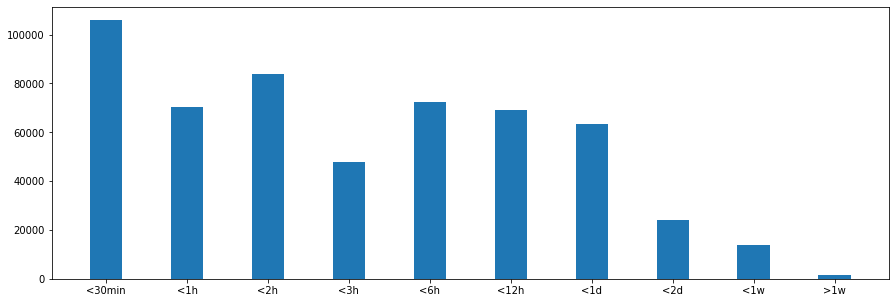

In [134]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 5))
plt.bar(times, numbers, width=0.4)

plt.show()


<AxesSubplot:>

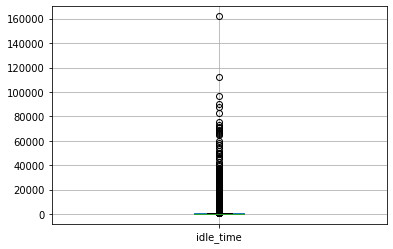

In [135]:
dfbox = pd.DataFrame(df_points['idle_time'])
dfbox.boxplot()

In [136]:
dfbox.quantile([0.25,0.5,0.75,1])

,idle_time
0.25,42.0
0.50,136.0
0.75,507.0
1.00,161964.0


In [137]:
def f(row):
    if row['idle_time'] < 42:
        val = 1
    elif row['idle_time'] < 136:
        val = 2
    elif row['idle_time'] < 507:
        val = 3
    else:
        val = 4
    return val

df_points['idle_time_class'] = df_points.apply(f, axis=1)

In [138]:
df_points.to_csv('../data/df_points_nosplit/df_points_2021.csv', index=False)

In [139]:
df_points.head()

,bike_id,lat,lng,dt_start,dt_end,hex_id,in_zone,zone_name,end_station_number,temp,rain,snow,wind_speed,humidity,year,month,day,start_min,idle_time,idle_time_class
0,72165,51.351547,12.382658,1609456894,1,881f1a8cb9fffff,0,0,0,2.72,0.0,0.0,4.02,72.0,2020,12,3,1402,1529,4
1,75838,51.331022,12.316226,1609456924,1,881f1a8dd7fffff,1,Pinke Zone Leipzig West 1€,0,2.72,0.0,0.0,4.02,72.0,2020,12,3,1402,5519,4
2,74466,51.355200,12.370664,1609456989,1,881f1a8c87fffff,1,Pinke Zone Leipzig Ost 1€,0,2.72,0.0,0.0,4.02,72.0,2020,12,3,1403,86,2
3,73806,51.328693,12.346637,1609457141,1,881f1a164dfffff,0,0,0,2.72,0.0,0.0,4.02,72.0,2020,12,3,1406,886,4
4,75854,51.331707,12.371241,1609457821,1,881f1a164bfffff,1,Blaue Zone Leipzig Ost 0€,0,2.72,0.0,0.0,4.02,72.0,2020,12,3,1417,262,3
